# House Price Predictor
#### A Kaggle Competition

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns

In [2]:
# Import Data

raw_train_data = pd.read_csv('train.csv')
raw_test_data = pd.read_csv('test.csv')

raw_data = pd.concat([raw_train_data, raw_test_data]).reset_index(drop=True)

# raw_data.info()
# train: ID 1 - 1460, test: ID 1461 - 2919

## Investigate SalePrice + Reduce Skew

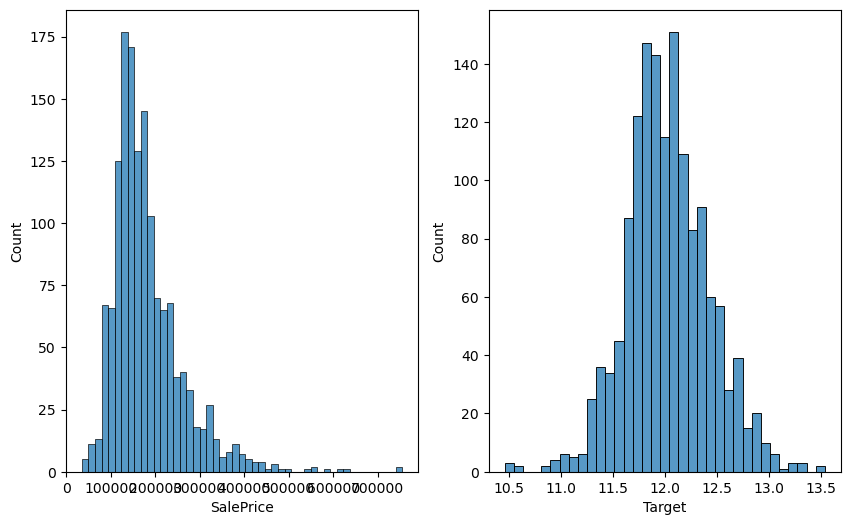

Before Transform:
Skew: 1.8828757597682129
Kurtosis: 6.536281860064529
-----------------------
After Transform:
Skew: 0.12134661989685329
Kurtosis: 0.809519155707878


In [3]:
# print(raw_train_data.SalePrice.describe())

transformed_target = np.log1p(raw_train_data.SalePrice)
raw_train_data['Target'] = transformed_target

fig, axs = plt.subplots(1, 2, figsize=(10,6))

sns.histplot(raw_train_data.SalePrice, ax=axs[0])
sns.histplot(raw_train_data.Target, ax=axs[1])

plt.show()

print('Before Transform:')
print(f'Skew: {raw_train_data.SalePrice.skew()}')
print(f'Kurtosis: {raw_train_data.SalePrice.kurt()}')

print('-----------------------')

print('After Transform:')
print(f'Skew: {raw_train_data.Target.skew()}')
print(f'Kurtosis: {raw_train_data.Target.kurt()}')

raw_data['Target'] = transformed_target
# print(raw_data.SalePrice)

## Missing Values

In [4]:
# Drop the Id column and all the columns with significant amounts of missing data, i.e. anything missing over 200 
## entries, I've also dropped Utilities as these are all identical apart from 3 entries

missing_vals = raw_data.isnull().sum().sort_values()
drop_cols = list(missing_vals[(missing_vals > 200) & (missing_vals.index != 'Target')].index)
drop_cols += ['Id', 'Utilities']

print(f'Drop: {drop_cols}')

data = raw_data.drop(drop_cols, axis=1)


data.MSZoning = raw_data.apply(lambda row: row.MSZoning if type(row.MSZoning) == 'String' else 
                               raw_data[raw_data.MSSubClass == row.MSSubClass].MSZoning.mode(), axis=1)

for col in ['Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Electrical', 'KitchenQual', 'Functional', 
            'SaleType']:
    data[col] = raw_data[col].apply(lambda x: raw_data[col].mode()[0] if pd.isna(x) else x)


data.at[2217, 'BsmtQual'] = raw_data.BsmtQual.mode()
data.at[2218, 'BsmtQual'] = raw_data.BsmtQual.mode()

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 
            'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = raw_data[col].apply(lambda x: 'None' if pd.isna(x) else x)


for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars',
            'GarageArea']:
    data[col] = raw_data[col].apply(lambda x: 0 if pd.isna(x) else x)

    
for col in ['GarageYrBlt']:
    data[col] = raw_data[col].apply(lambda x: raw_data[col].mean() if pd.isna(x) else x)

  
# data.info()

Drop: ['LotFrontage', 'FireplaceQu', 'SalePrice', 'Fence', 'Alley', 'MiscFeature', 'PoolQC', 'Id', 'Utilities']


## Convert Ordinal Variables

In [5]:
# Now to transform/make the features usable. As there are already so many features in the data I want to avoid 
## simple binary encoding where possible - instead for the ordinal variables I'll assign a number value

for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir', 'KitchenQual',
            'GarageFinish', 'GarageQual', 'GarageCond']:
    
    if col == 'BsmtExposure':
        rating_dict = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'None':0}
    else:
        rating_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0, 'Fin':3, 'RFn':2, 'Unf':1, 'Y':1, 'N':0}

    data[col] = data[col].map(rating_dict)
   
print(len(data.columns))

73


## Inspect Distribution of Features

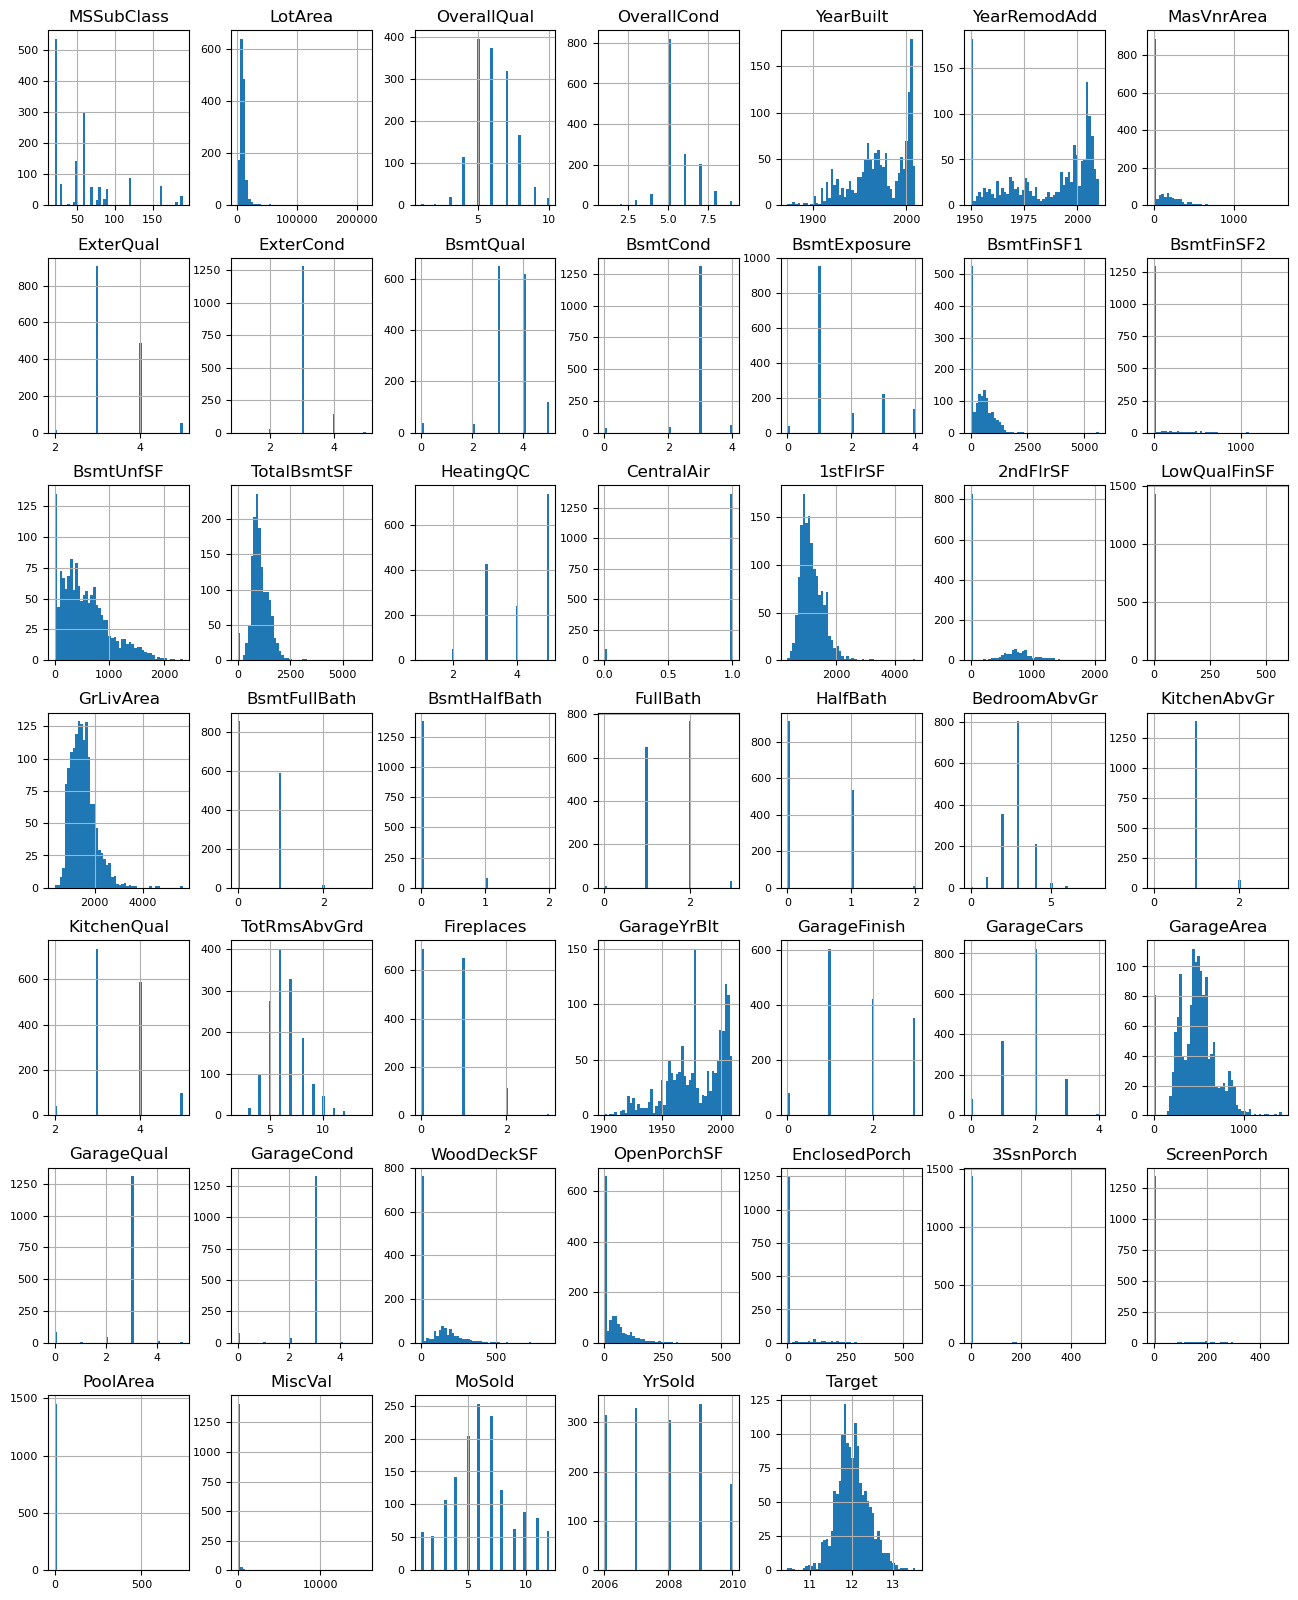

In [6]:
train_data = data.iloc[:1460,:]
numerical_td = train_data.select_dtypes(include=['float64', 'int64'])
numerical_td.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [7]:
## Try transforming the columms

for col in numerical_td.columns:
    if numerical_td[col].skew() > 5:
        print(col)
#         plt.figure()
#         sns.displot(numerical_td[col])
#         print(numerical_td[col].value_counts())
        print('Before Transform:')
        print(f'Kurtosis: {train_data[col].kurt()}')
        print(f'Skew: {train_data[col].skew()}')

        transformed = np.log1p(train_data[col])
        
        
        print('After Transform:')
        print(f'Kurtosis: {transformed.kurt()}')
        print(f'Skew: {transformed.skew()}')
        
        print('-----------------------')
        
        data[col] = np.log1p(data[col])


LotArea
Before Transform:
Kurtosis: 203.24327101886033
Skew: 12.207687851233496
After Transform:
Kurtosis: 4.713821643757218
Skew: -0.13740448122837784
-----------------------
LowQualFinSF
Before Transform:
Kurtosis: 83.2348166744174
Skew: 9.011341288465387
After Transform:
Kurtosis: 54.39233558300691
Skew: 7.460316514621369
-----------------------
3SsnPorch
Before Transform:
Kurtosis: 123.66237944970538
Skew: 10.304342032693112
After Transform:
Kurtosis: 58.420235119148096
Skew: 7.734974870241933
-----------------------
PoolArea
Before Transform:
Kurtosis: 223.2684989181717
Skew: 14.828373640750588
After Transform:
Kurtosis: 204.68161677491244
Skew: 14.363102459725052
-----------------------
MiscVal
Before Transform:
Kurtosis: 701.0033422801193
Skew: 24.476794188821916
After Transform:
Kurtosis: 25.438588959489625
Skew: 5.170703861673264
-----------------------


## Investigate Correlation

<AxesSubplot:>

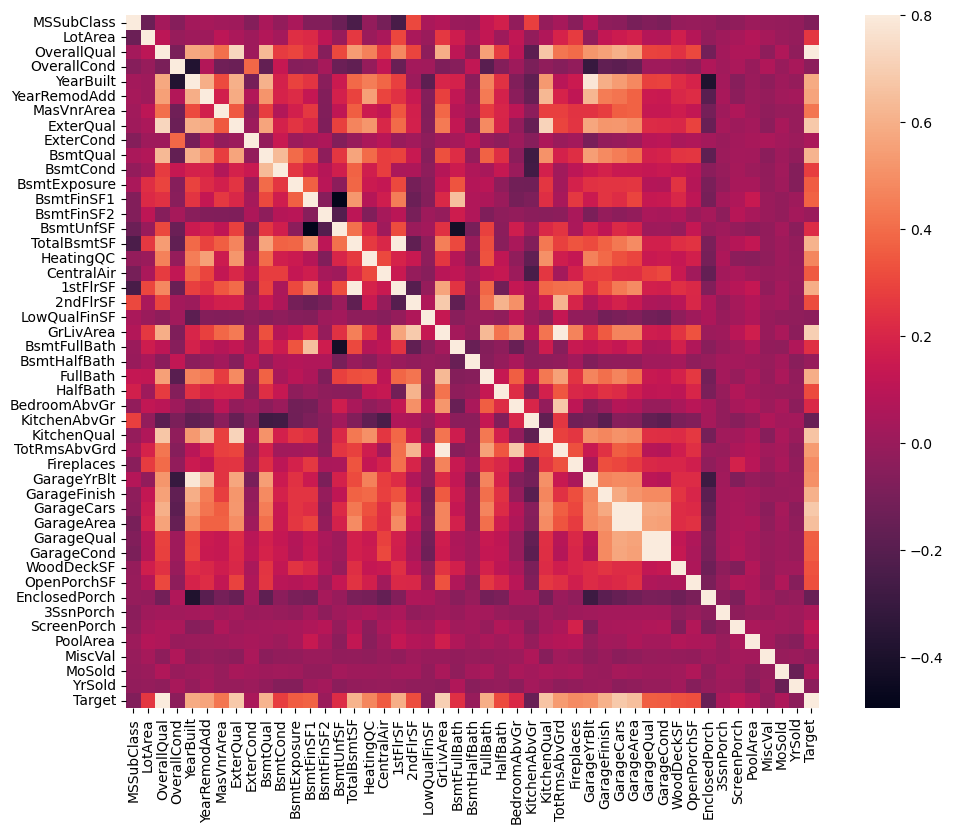

In [8]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [9]:
# Find features that are closely correlated and remove those with lower correlation to SalePrice

correlated = []
redundant_features = []

for col in corrmat.columns:    
    for row in corrmat.index:
        if col == row:
            break
            
        if abs(corrmat[col][row])>0.7:       
            correlated.append([col, row])

# print(correlated)

for pair in correlated:
    if 'Target' in pair:
        break
    
    elif corrmat.Target[pair[0]] > corrmat.Target[pair[1]]:
        redundant_features.append(pair[1])
    
    else:
        redundant_features.append(pair[0])
        
print('Redundant Features:')        
print(redundant_features)

reduced_data = data.drop(redundant_features, axis=1)

# print(reduced_data.dtypes[reduced_data.dtypes != 'object'])

Redundant Features:
['ExterQual', '1stFlrSF', 'KitchenQual', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'GarageCond']


## Encode the Remaining Categorical Data

In [10]:
# Binary encode:

def encode(dataframe, column):
    if column in dataframe.columns:
        dummy = pd.get_dummies(dataframe[column], prefix=column)
        df = dataframe.join(dummy)
        df.drop(column, axis=1, inplace=True)
        return df
    else:
        print(f'Error - {column} column not found in DataFrame.')
        return dataframe

        
# data_encoded = data
reduced_data_encoded = reduced_data

for col in reduced_data_encoded.select_dtypes(include = ['object']).columns:
        
#     data_encoded = encode(data_encoded, col)
    reduced_data_encoded = encode(reduced_data_encoded, col)    


# # Label Encode:

# reduced_data_encoded = reduced_data

# for col in reduced_data_encoded.select_dtypes(include = ['object']).columns:
    
#     lbl = LabelEncoder() 
#     lbl.fit(list(reduced_data_encoded[col].values)) 
#     reduced_data_encoded[col] = lbl.transform(list(reduced_data_encoded[col].values))

print(reduced_data_encoded.shape)

(2919, 227)


## Split data and standardise


In [11]:
X = reduced_data_encoded.drop('Target', axis=1).iloc[:1460,:]
y = reduced_data_encoded.Target.iloc[:1460]

X_test = reduced_data_encoded.drop('Target', axis=1).iloc[1460:,:]
y_test = reduced_data_encoded.Target.iloc[1460:]

# print(X_test.head())

# Standardise all data

# print(data.columns)

ct = ColumnTransformer([('scale',StandardScaler(),X_test.select_dtypes(include=['float64', 'int64']).columns)], 
                         remainder = 'passthrough')

X = pd.DataFrame(ct.fit_transform(X), columns=X_test.columns)

X_test = pd.DataFrame(ct.transform(X_test), columns=X.columns)
X_test.index = y_test.index

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 10, train_size = 0.8)

## Select Model

In [12]:
### Model Selection
pipeline = Pipeline([('clf', Ridge())])

param1 = {'clf': [Ridge(max_iter = 20000)], 'clf__alpha': np.logspace(-1,3, num=10)}
param2 = {'clf': [Lasso(max_iter = 20000)], 'clf__alpha': np.logspace(-1,3, num=10)}
param3 = {'clf': [RandomForestRegressor(criterion = 'absolute_error')]}


param_grid = [param1, param2, param3]

grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = 'neg_mean_absolute_percentage_error',
                    cv = 10, return_train_score = True, verbose = 3)

grid.fit(X_train, y_train)

print(grid.best_estimator_)
print(grid.best_score_)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV 1/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.007) total time=   2.2s
[CV 2/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.008) total time=   0.0s
[CV 3/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.007) total time=   0.0s
[CV 4/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.007) total time=   0.0s
[CV 5/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.006) total time=   0.0s
[CV 6/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.008) total time=   0.0s
[CV 7/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.005, test=-0.009) total time=   0.0s
[CV 8/10] END clf=Ridge(max_iter=20000), clf__alpha=0.1;, score=(train=-0.006, test=-0.007) total time=   0.0s
[CV 9/10] END clf=Ridge(max_iter=20000), clf__alp

[CV 10/10] END clf=Ridge(max_iter=20000), clf__alpha=129.15496650148827;, score=(train=-0.007, test=-0.008) total time=   0.0s
[CV 1/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.008, test=-0.008) total time=   0.0s
[CV 2/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.008, test=-0.007) total time=   0.0s
[CV 3/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.008, test=-0.008) total time=   0.0s
[CV 4/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.008, test=-0.009) total time=   0.0s
[CV 5/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.008, test=-0.008) total time=   0.0s
[CV 6/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.007, test=-0.009) total time=   0.0s
[CV 7/10] END clf=Ridge(max_iter=20000), clf__alpha=359.38136638046257;, score=(train=-0.007, test=-0.008) total time

[CV 8/10] END clf=Lasso(max_iter=20000), clf__alpha=5.994842503189409;, score=(train=-0.025, test=-0.025) total time=   0.0s
[CV 9/10] END clf=Lasso(max_iter=20000), clf__alpha=5.994842503189409;, score=(train=-0.026, test=-0.023) total time=   0.0s
[CV 10/10] END clf=Lasso(max_iter=20000), clf__alpha=5.994842503189409;, score=(train=-0.026, test=-0.023) total time=   0.0s
[CV 1/10] END clf=Lasso(max_iter=20000), clf__alpha=16.68100537200059;, score=(train=-0.025, test=-0.025) total time=   0.0s
[CV 2/10] END clf=Lasso(max_iter=20000), clf__alpha=16.68100537200059;, score=(train=-0.025, test=-0.028) total time=   0.0s
[CV 3/10] END clf=Lasso(max_iter=20000), clf__alpha=16.68100537200059;, score=(train=-0.025, test=-0.026) total time=   0.0s
[CV 4/10] END clf=Lasso(max_iter=20000), clf__alpha=16.68100537200059;, score=(train=-0.025, test=-0.026) total time=   0.0s
[CV 5/10] END clf=Lasso(max_iter=20000), clf__alpha=16.68100537200059;, score=(train=-0.025, test=-0.025) total time=   0.0s

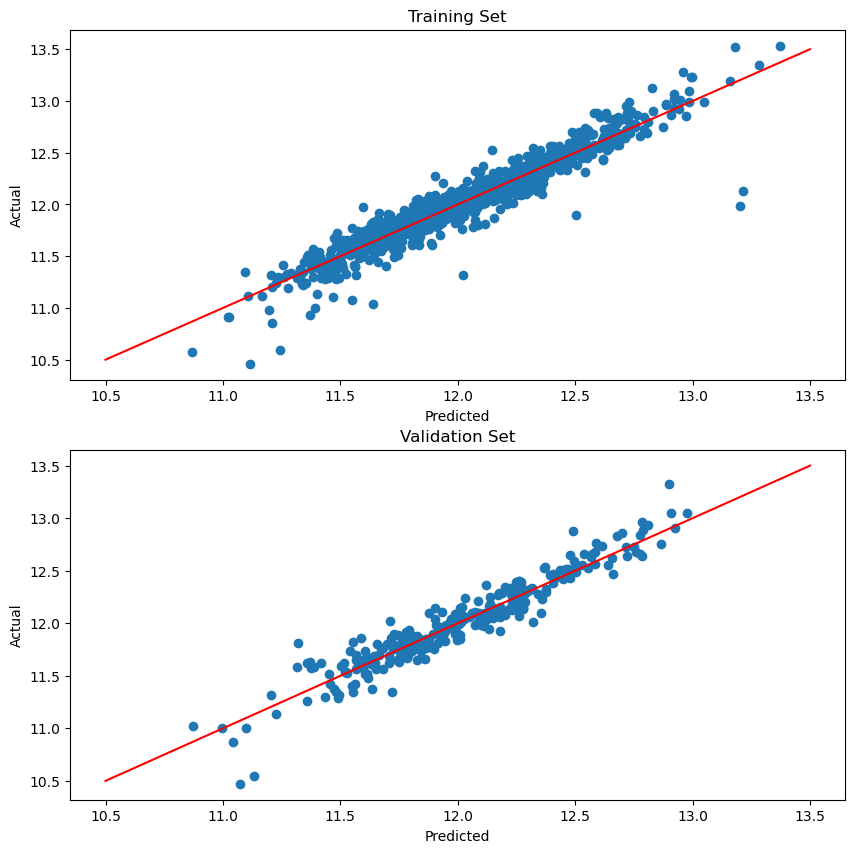

In [13]:
# Visualise Results
model = grid.best_estimator_

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

fig, axs = plt.subplots(2, 1, figsize = (10,10))

axs[0].scatter(y_train_pred, y_train)
axs[0].plot([10.5,13.5], [10.5, 13.5],'r')
axs[0].set_title('Training Set')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

axs[1].scatter(y_val_pred, y_val)
axs[1].plot([10.5,13.5], [10.5, 13.5],'r')
axs[1].set_title('Validation Set')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.show()


## Tune Model

In [ ]:
# Fine tune model (Random Forest)


# ##FROM BELOW##
# for f in unimportant_features:
#     X_train.drop(f, axis = 1, inplace = True)
#     X_val.drop(f, axis = 1, inplace = True)


# ##FROM BELOW##

fine_param_grid = {'oob_score': [False], 'max_features': [10, 40, 70, 100]} 

fine_grid = GridSearchCV(estimator = model['clf'], param_grid = fine_param_grid, cv = 5, return_train_score = True, 
                         scoring = 'neg_mean_absolute_percentage_error',  verbose = 2)

fine_grid.fit(X_train, y_train)

print(fine_grid.best_estimator_)
print(fine_grid.best_score_)

In [15]:
# Fine tune model (Ridge)
fine_param_grid = {'alpha': np.logspace(-4, 4, 20), 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag',
                                                                'saga']}
fine_grid = GridSearchCV(model['clf'], fine_param_grid, cv=5, scoring = 'neg_mean_absolute_percentage_error',  
                         verbose = 2)

fine_grid.fit(X_train, y_train)

print(fine_grid.best_estimator_)
print(fine_grid.best_score_)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV] END ..........................alpha=0.0001, solver=auto; total time=   0.0s
[CV] END ..........................alpha=0.0001, solver=auto; total time=   0.0s
[CV] END ..........................alpha=0.0001, solver=auto; total time=   0.0s
[CV] END ..........................alpha=0.0001, solver=auto; total time=   0.0s
[CV] END ..........................alpha=0.0001, solver=auto; total time=   0.0s
[CV] END ...........................alpha=0.0001, solver=svd; total time=   0.0s
[CV] END ...........................alpha=0.0001, solver=svd; total time=   0.0s
[CV] END ...........................alpha=0.0001, solver=svd; total time=   0.0s
[CV] END ...........................alpha=0.0001, solver=svd; total time=   0.0s
[CV] END ...........................alpha=0.0001, solver=svd; total time=   0.0s
[CV] END ......................alpha=0.0001, solver=cholesky; total time=   0.0s
[CV] END ......................alpha=0.0001, s

[CV] END ...........alpha=0.0006951927961775605, solver=saga; total time=   1.2s
[CV] END ...........alpha=0.0006951927961775605, solver=saga; total time=   0.8s
[CV] END ...........alpha=0.0006951927961775605, solver=saga; total time=   1.3s
[CV] END ...........alpha=0.0006951927961775605, solver=saga; total time=   1.4s
[CV] END ...........alpha=0.0018329807108324356, solver=auto; total time=   0.0s
[CV] END ...........alpha=0.0018329807108324356, solver=auto; total time=   0.0s
[CV] END ...........alpha=0.0018329807108324356, solver=auto; total time=   0.0s
[CV] END ...........alpha=0.0018329807108324356, solver=auto; total time=   0.0s
[CV] END ...........alpha=0.0018329807108324356, solver=auto; total time=   0.0s
[CV] END ............alpha=0.0018329807108324356, solver=svd; total time=   0.0s
[CV] END ............alpha=0.0018329807108324356, solver=svd; total time=   0.0s
[CV] END ............alpha=0.0018329807108324356, solver=svd; total time=   0.0s
[CV] END ............alpha=0

[CV] END .............alpha=0.012742749857031334, solver=sag; total time=   1.0s
[CV] END .............alpha=0.012742749857031334, solver=sag; total time=   1.1s
[CV] END ............alpha=0.012742749857031334, solver=saga; total time=   1.3s
[CV] END ............alpha=0.012742749857031334, solver=saga; total time=   1.3s
[CV] END ............alpha=0.012742749857031334, solver=saga; total time=   0.9s
[CV] END ............alpha=0.012742749857031334, solver=saga; total time=   1.3s
[CV] END ............alpha=0.012742749857031334, solver=saga; total time=   1.3s
[CV] END .............alpha=0.03359818286283781, solver=auto; total time=   0.0s
[CV] END .............alpha=0.03359818286283781, solver=auto; total time=   0.0s
[CV] END .............alpha=0.03359818286283781, solver=auto; total time=   0.0s
[CV] END .............alpha=0.03359818286283781, solver=auto; total time=   0.0s
[CV] END .............alpha=0.03359818286283781, solver=auto; total time=   0.0s
[CV] END ..............alpha

[CV] END ..............alpha=0.23357214690901212, solver=sag; total time=   0.9s
[CV] END ..............alpha=0.23357214690901212, solver=sag; total time=   0.9s
[CV] END ..............alpha=0.23357214690901212, solver=sag; total time=   0.5s
[CV] END ..............alpha=0.23357214690901212, solver=sag; total time=   0.9s
[CV] END ..............alpha=0.23357214690901212, solver=sag; total time=   0.9s
[CV] END .............alpha=0.23357214690901212, solver=saga; total time=   1.2s
[CV] END .............alpha=0.23357214690901212, solver=saga; total time=   1.2s
[CV] END .............alpha=0.23357214690901212, solver=saga; total time=   0.8s
[CV] END .............alpha=0.23357214690901212, solver=saga; total time=   1.1s
[CV] END .............alpha=0.23357214690901212, solver=saga; total time=   1.2s
[CV] END ...............alpha=0.615848211066026, solver=auto; total time=   0.0s
[CV] END ...............alpha=0.615848211066026, solver=auto; total time=   0.0s
[CV] END ...............alph

[CV] END ................alpha=4.281332398719396, solver=sag; total time=   0.4s
[CV] END ................alpha=4.281332398719396, solver=sag; total time=   0.4s
[CV] END ................alpha=4.281332398719396, solver=sag; total time=   0.3s
[CV] END ................alpha=4.281332398719396, solver=sag; total time=   0.4s
[CV] END ................alpha=4.281332398719396, solver=sag; total time=   0.4s
[CV] END ...............alpha=4.281332398719396, solver=saga; total time=   0.6s
[CV] END ...............alpha=4.281332398719396, solver=saga; total time=   0.6s
[CV] END ...............alpha=4.281332398719396, solver=saga; total time=   0.5s
[CV] END ...............alpha=4.281332398719396, solver=saga; total time=   0.6s
[CV] END ...............alpha=4.281332398719396, solver=saga; total time=   0.6s
[CV] END ..............alpha=11.288378916846883, solver=auto; total time=   0.0s
[CV] END ..............alpha=11.288378916846883, solver=auto; total time=   0.0s
[CV] END ..............alpha

[CV] END ................alpha=78.47599703514607, solver=sag; total time=   0.1s
[CV] END ................alpha=78.47599703514607, solver=sag; total time=   0.0s
[CV] END ................alpha=78.47599703514607, solver=sag; total time=   0.0s
[CV] END ................alpha=78.47599703514607, solver=sag; total time=   0.0s
[CV] END ...............alpha=78.47599703514607, solver=saga; total time=   0.1s
[CV] END ...............alpha=78.47599703514607, solver=saga; total time=   0.1s
[CV] END ...............alpha=78.47599703514607, solver=saga; total time=   0.1s
[CV] END ...............alpha=78.47599703514607, solver=saga; total time=   0.1s
[CV] END ...............alpha=78.47599703514607, solver=saga; total time=   0.1s
[CV] END ................alpha=206.913808111479, solver=auto; total time=   0.0s
[CV] END ................alpha=206.913808111479, solver=auto; total time=   0.0s
[CV] END ................alpha=206.913808111479, solver=auto; total time=   0.0s
[CV] END ................alp

[CV] END ................alpha=1438.44988828766, solver=saga; total time=   0.0s
[CV] END ................alpha=1438.44988828766, solver=saga; total time=   0.0s
[CV] END ................alpha=1438.44988828766, solver=saga; total time=   0.0s
[CV] END ................alpha=1438.44988828766, solver=saga; total time=   0.0s
[CV] END ................alpha=1438.44988828766, solver=saga; total time=   0.0s
[CV] END ...............alpha=3792.690190732246, solver=auto; total time=   0.0s
[CV] END ...............alpha=3792.690190732246, solver=auto; total time=   0.0s
[CV] END ...............alpha=3792.690190732246, solver=auto; total time=   0.0s
[CV] END ...............alpha=3792.690190732246, solver=auto; total time=   0.0s
[CV] END ...............alpha=3792.690190732246, solver=auto; total time=   0.0s
[CV] END ................alpha=3792.690190732246, solver=svd; total time=   0.0s
[CV] END ................alpha=3792.690190732246, solver=svd; total time=   0.0s
[CV] END ................alp

In [17]:
tuned_model = fine_grid.best_estimator_
# tuned_model.set_params(n_estimators = 200)

tuned_model.fit(X_train, y_train)

y_pred = tuned_model.predict(X_val)
y_v = y_val.reset_index(drop=True)

# print(y_pred)

## Transform back:

y_pred = np.expm1(y_pred)
y_v = np.expm1(y_v)

# print(y_pred)


mae = sum([abs(y_pred[i] - y_v[i]) for i in range(len(X_val))])/len(X_val)

#12/08/23 am: 18417.63033219178
#14/08/23 (reduced features): 19011.93
#15/08/23 (0.0001 importance removed): 18092.599
#15/08/23 (0.0005 importance removed): 18064.428
#15/08/23 (0.001 importance removed): 18062.002320205476
#15/08/23 (0.0025 importance removed): 17866.970967465742
# 21/08/23 remove more with missing values + 0.0025 importance removed: 18505.446241438363 but less CV
# 22/08/23 no longer remove low-correlated values to SalePrice (unimportant not removed): 17610.689880136975
# 22/08/23 <0.0005 removed: 17359.01537671233
# 22/08/23 <0.001 removed: 17269.110839041106
# 22/08/23 none removed: 17187.73107020548
# 22/08/23 <0.0025 removed (label encode not binary): 17432.1842208904
# 08/09/23 Un-skewed the SalePrice: 16913.9433737341
# 09/09/23 Un-skewed all features with skew > 5: 16406.543852366725
# 09/09/23 Un-skewed all features with skew > 3: 16508.356426675735
print(mae)

16468.80964482107


In [ ]:
## For Random Forest Only
feature_df = pd.DataFrame({'feature': X_train.columns,'importance': tuned_model.feature_importances_})

unimportant_features = feature_df[feature_df.importance < 0.001].feature

print(len(unimportant_features))
print(len(X_train.columns))

In [18]:
print(tuned_model.get_params())
print(tuned_model)

{'alpha': 29.763514416313132, 'copy_X': True, 'fit_intercept': True, 'max_iter': 20000, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'svd', 'tol': 0.001}
Ridge(alpha=29.763514416313132, max_iter=20000, solver='svd')


In [19]:
# Predict outcomes

predictions = pd.DataFrame()

predictions['Id'] = X_test.index + 1
predictions['SalePrice'] = np.expm1(model.predict(X_test))

print(predictions)

predictions.to_csv('predictions.csv', index=False)


        Id      SalePrice
0     1461  116554.641620
1     1462  145913.411953
2     1463  177128.097990
3     1464  192788.703850
4     1465  194529.589172
...    ...            ...
1454  2915   86210.148907
1455  2916   81344.746605
1456  2917  168518.001917
1457  2918  113640.840413
1458  2919  234653.713966

[1459 rows x 2 columns]
